# Transfer Learning

Note: While this project was completed as a part of the Flatiron School Data Science Bootcamp, this notebook was created after the project was graded.

In the pneumonia_cnn.ipynb notebook, I created a convolutional neural network from scratch that can diagnose pneumonia from a chest X-ray. In this notebook, I will attempt to use transfer learning for the same purpose.

In [54]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.utils import to_categorical
import os
import datetime
import matplotlib.pyplot as plt
from keras import regularizers, initializers
%matplotlib inline
plt.style.use('ggplot')

# Import modules needed for creating a CNN model
from keras.applications import ResNet50V2
import keras
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Data

I process the data the same way I did in pneumonia_cnn.ipynb.

In [55]:
# Main directory
maindir = 'C:/Users/david/Documents/Flatiron/phase_4/PneumoniaData/ZhangLabData/CellData/chest_xray/'
# Subdirectories in main directory
subdirs = ['train/NORMAL/','train/PNEUMONIA/','test/NORMAL/','test/PNEUMONIA/']

Below are the same functions from pneumonia_cnn.ipynb.

crop_resize_image crops an image to the desired aspect ratio, then downsamples it to the desired pixel dimensions.

The function differs slightly from that in pneumonia_cnn.ipynb because I added an offset option.

In [56]:
def crop_resize_image(filepath, dims=None, rescale=None, offset=None, return_orig_dims=False):
    """
    Reads in an image, crops it, and resizes it so that the final array has dimensions dims.
    Input:
    filepath: Full directory path to image.
    dims: Desired dimensions of image as tuple. Default is None, in which case no cropping or resizing is done.
    rescale: Number by which to multiply the image. Default is to not rescale.
    offset: Number to add or subtract. Default is to not use offset.
    return_orig_dims: Tells function whether or not to return the original dimensions of the image. Default is False.
    """
    img = load_img(filepath, color_mode='grayscale')
    if dims == None:
        img_array = img_to_array(img)
    # Crop and resize if dims is specified
    else:
        desired_aspect = dims[0]/dims[1]
        if img.height/img.width > desired_aspect:
            desired_height = img.width * desired_aspect
            cut = np.round((img.height - desired_height)/2,0)
            img_crop = img.crop((0,cut,img.width,img.height-cut))
        else:
            desired_width = img.height / desired_aspect
            cut = np.round((img.width - desired_width)/2,0)
            img_crop = img.crop((cut,0,img.width-cut,img.height))
        img_resize = img_crop.resize((dims[1],dims[0]))
        img_array = img_to_array(img_resize)
        
    # Rescale the image if rescale is defined
    if rescale != None:
        img_array *= rescale
    if offset != None:
        img_array += offset
    if return_orig_dims:
        return img_array[:,:,0], [img.height, img.width]
    else:
        return img_array[:,:,0]

get_image_filenames collects the filenames of images to use for the analysis.

In [57]:
def get_image_filenames(rootdir, subdir, size='all', size2=0):
    """
    This function collects filenames of images.
    Input:
    rootdir: The directory that contains all of the data.
    subdir: Indicates whether to collect images from 'train' or 'test'.
    size: Number of images to collect. Default is collect all the images.
    size2: If indicated, it is the number of images to collect for a second sample.
        This is useful for creating a validation sample which won't overlap with the training sample.
        
    Output:
    One list of files and one list of labels (if size2=0) or two lists of files and two lists of labels if size2>0.
    """
    # Get image names from NORMAL
    directory = rootdir + subdir + '/NORMAL/'
    files_normal = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    # Get image names from PNEUMONIA
    directory = rootdir + subdir + '/PNEUMONIA/'
    files_pneum = [directory+x for x in os.listdir(directory) if 'jpeg' in x]
    files_bacteria = [x for x in files_pneum if 'BACTERIA' in x]
    files_virus = [x for x in files_pneum if 'VIRUS' in x]

    # Check to make sure we did not ask for more files than exist in the directories
    if size != 'all':
        check = (len(files_normal) >= size+size2) * (len(files_bacteria) >= size+size2) * (len(files_virus) >= size+size2)
        if check == False:
            raise Exception('Asked for more images than are actually present')
    
    if size == 'all':
        filenames = np.append(files_normal, np.append(files_bacteria, files_virus))

        return filenames

    else:
        sample_normal = np.random.choice(files_normal, size+size2, replace=False)
        sample_bacteria = np.random.choice(files_bacteria, size+size2, replace=False)
        sample_virus = np.random.choice(files_virus, size+size2, replace=False)
            
        if size2 == 0:
            filenames = np.append(sample_normal, np.append(sample_bacteria, sample_virus))

            return filenames
        else:
            filenames1 = np.append(sample_normal[0:size], np.append(sample_bacteria[0:size],sample_virus[0:size]))
            filenames2 = np.append(sample_normal[size:], np.append(sample_bacteria[size:],sample_virus[size:]))

            return filenames1, filenames2

create_tensors takes filenames and outputs a tensor that can be input to a neural network.

The function below differs slightly from the one in pneumonia_cnn.ipynb because it can create multi-channel tensors and because it has rescale and offset options.

In [58]:
def create_tensors(filenames, dims, OHE=True, n_channels=1, rescale=None, offset=None):
    """
    Function for turning a list of filenames into tensors that can be input to a CNN model.
    Inputs:
    filenames: List of filenames.
    dims: The desired dimensions of the output.
    OHE: Indicates whether the class labels should be one-hot encoded. Default is True.
    n_channels: Sets the number of channels. The x-rays are all grayscale, but we can pretend
    there are multiple channels by putting the grayscale values in each channel.
    rescale: Number by which image will be multiplied.
    offset: Number added or subtract from image.
    """
    x = np.zeros((len(filenames), dims[0], dims[1]))
    y = np.zeros(len(filenames))
    # Save the original dimensions (will use after fitting model)
    dims_orig = np.zeros((len(filenames),2))

    # Loop over files
    for n, file in enumerate(filenames):
        # Add image to tensor and dimensions to dims_orig
        x[n], dims_orig[n] = crop_resize_image(file, dims, rescale=rescale, offset=offset, return_orig_dims=True)
        
        # Determine the class of the image
        if 'NORMAL' in file:
            y[n] = 0
        elif 'BACTERIA' in file:
            y[n] = 1
        elif 'VIRUS' in file:
            y[n] = 2
        else:
            raise Exception(f"Cannot determine class for {file}")

    # One-hot encode the classes if OHE is True
    if OHE:
        y = to_categorical(y, 3)

    # Reshape x into a tensor
    x = x.reshape(-1, dims[0], dims[1], 1)
    # Duplicate images 3 times if we want three channels
    if n_channels == 3:
        x = np.stack((x,x,x),3)[:,:,:,:,0]
    return x, y, dims_orig

display_metrics creates and prints a classification report, a confusion matrix, and ROC curves. Since there are three classes, three ROC curves are created by considering one class vs. the others. Classification reports and confusion matrices will be created for train, validation, and test datasets. ROC curves will only be created for the test dataset.

In [59]:
def display_metrics(model, train_data=None, val_data=None, test_data=None):
    """
    Function for displaying classification reports, confusion matrices, and ROC curves.
    Classification reports and confusion matrices are created for train, validation, and test data.
    ROC curves are only created for the test data.
    
    Inputs:
    model: The fitted model.
    train_data, val_data, test_data: (x,y) tuple containing different types of data.
    Default is None, in which case no classification report or confusion matrix will be displayed.
    
    """
    # Classification reports
    
    count = 0
    
    if train_data != None:
        print("Classification Report: Train")
        print(classification_report(np.argmax(train_data[1], axis=-1),
                                    np.argmax(model.predict(train_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if val_data != None:
        print("Classification Report: Validation")
        print(classification_report(np.argmax(val_data[1], axis=-1),
                                    np.argmax(model.predict(val_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
    if test_data != None:
        print("Classification Report: Test")
        print(classification_report(np.argmax(test_data[1], axis=-1),
                                    np.argmax(model.predict(test_data[0]), axis=-1),
                                    labels=[0,1,2],
                                    target_names=['NORMAL','BACTERIA','VIRUS'],
                                    digits=3))
        count += 1
        
    # Confusion Matrices
    fig, ax = plt.subplots(ncols=count, figsize=(count*5,4))
    n = 0
    if train_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(train_data[1], axis=-1), np.argmax(model.predict(train_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_train = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Train')
        ax[n].grid(False)
        n += 1
    if val_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(val_data[1], axis=-1), np.argmax(model.predict(val_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_val = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Validation')
        ax[n].grid(False)
        n += 1
    if test_data != None:
        # Get confusion matrix
        cf = confusion_matrix(np.argmax(test_data[1], axis=-1), np.argmax(model.predict(test_data[0]), axis=-1))
        # Calculate binary accuracy (healthy vs. pneumonia)
        acc_test = (np.sum(cf)-cf[0,1]-cf[0,2]-cf[1,0]-cf[2,0])/np.sum(cf)
        # Display confusion matrix
        ConfusionMatrixDisplay(cf, display_labels=['NORMAL','BACTERIA','VIRUS']).plot(ax=ax[n])
        ax[n].set_title('Test')
        ax[n].grid(False)

    fig.tight_layout()
    
    # Print binary accuracy (healthy vs. pneumonia)
    print('Binary Accuracy')
    print('Train:', round(acc_train,3))
    print('Validation:', round(acc_val,3))
    print('Test:', round(acc_test,3))
    
    # ROC curves (only test data)
    if test_data != None:
        fig2, ax2 = plt.subplots(figsize=(6,6))
        
        ax2.plot([0,1],[0,1])
        
        for i, case in enumerate(['NORMAL vs. Rest','BACTERIA vs. Rest','VIRUS vs. Rest']):
            fpr, tpr, thresh = roc_curve(test_data[1][:,i], model.predict(test_data[0])[:,i])
            ax2.plot(fpr, tpr, label=f"{case}: {round(auc(fpr, tpr),3)}")
        ax2.set_title('ROC Curve: Test Data')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()

plot_history makes a plot of the accuracy and loss for the training and validation datasets.

In [60]:
def plot_history(history):
    """
    Function to plot the loss and accuracy vs epoch for a model.
    Input is the history of a model.
    """
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch = range(len(acc))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))

    ax[0].plot(epoch, acc, label='Training')
    ax[0].plot(epoch, val_acc, label='Validation')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()

    ax[1].plot(epoch, loss, label='Training')
    ax[1].plot(epoch, val_loss, label='Validation')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

In [61]:
# Set random seed
np.random.seed(42)
# Size of train dataset
train_size = 500
# Size of validation dataset
val_size = 100

# Dimensions use mean aspect ratio.
dimensions = (129, 180) # This is what pneumonia_cnn.ipynb used

# Get list of images for train and validation
train_list, val_list = get_image_filenames(maindir,
                                           subdir='train',
                                           size=train_size,
                                           size2=val_size)

# Get list of images for test
test_list = get_image_filenames(maindir,
                                subdir='test',
                                size='all')

# Create tensors for train, validation, and test
x_train, y_train, dims_train = create_tensors(train_list, dimensions, OHE=True, n_channels=3, rescale=2/255, offset=-1.0)
x_val, y_val, dims_val = create_tensors(val_list, dimensions, OHE=True, n_channels=3, rescale=2/255, offset=-1.0)
x_test, y_test, dims_test = create_tensors(test_list, dimensions, OHE=True, n_channels=3, rescale=2/255, offset=-1.0)

### Base Model

I am going to use ResNet50V2 as the base model for transfer learning.

In [47]:
base_model = ResNet50V2(weights='imagenet',
                        input_shape=(129,180,3),
                        include_top=False)
base_model

94674944/94668760 [==============================] - 7s 0us/step


In [48]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 129, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 135, 186, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 65, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 67, 92, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [49]:
# Freeze the base model
base_model.trainable = False

In [53]:
inputs = keras.Input(shape=(129,180,3))

# Put scale_layer into model
x = base_model(inputs, training=False)

# Add global average pooling 2D layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add dropout layer
x = keras.layers.Dropout(0.2)(x)

# Add dense layer for output
outputs = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 129, 180, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 6, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 23,570,947
Trainable params: 6,147
Non-trainable params: 23,564,800
_________________________________________________________________


ResNet50V2 has far more parameters than the convolutional neural network I made. That network had 1,175,203 parameters while this one has over 23 million.

Below, I train the model on the data with only the weights connecting to the output layer unfrozen.

In [72]:
# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['acc'])

# Time how long it takes to fit the model
start = datetime.datetime.now()
# Fit the model
history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=30,
                    validation_data=(x_val, y_val))
end = datetime.datetime.now()
print(end-start)

Epoch 1/4
50/50 [==============================] - 24s 482ms/step - loss: 0.4546 - acc: 0.8080 - val_loss: 0.6219 - val_acc: 0.7800
Epoch 2/4
50/50 [==============================] - 25s 499ms/step - loss: 0.3997 - acc: 0.8433 - val_loss: 0.6879 - val_acc: 0.7300
Epoch 3/4
50/50 [==============================] - 25s 490ms/step - loss: 0.4097 - acc: 0.8300 - val_loss: 0.7740 - val_acc: 0.7200
Epoch 4/4
50/50 [==============================] - 25s 498ms/step - loss: 0.3904 - acc: 0.8407 - val_loss: 0.6370 - val_acc: 0.7633
0:01:42.598464


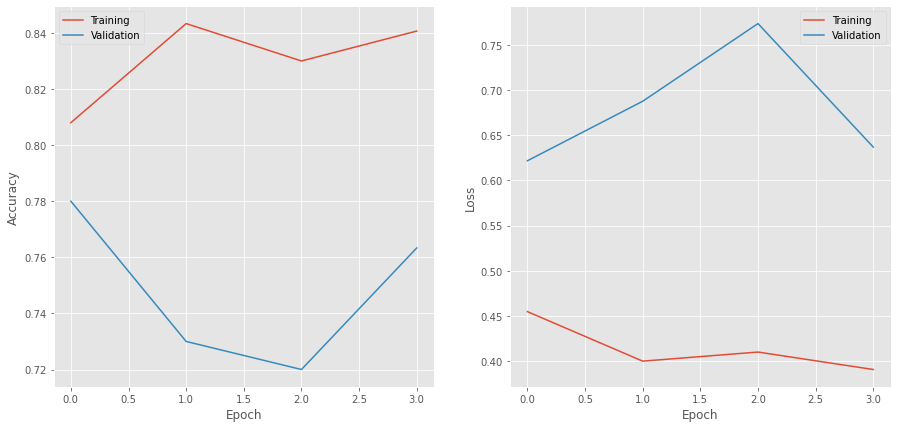

In [73]:
# Plot loss and accuracy vs epoch
plot_history(history)

Classification Report: Train
              precision    recall  f1-score   support

      NORMAL      0.948     0.980     0.964       500
    BACTERIA      0.939     0.798     0.863       500
       VIRUS      0.824     0.920     0.870       500

    accuracy                          0.899      1500
   macro avg      0.904     0.899     0.899      1500
weighted avg      0.904     0.899     0.899      1500

Classification Report: Validation
              precision    recall  f1-score   support

      NORMAL      0.879     0.940     0.908       100
    BACTERIA      0.776     0.590     0.670       100
       VIRUS      0.650     0.760     0.700       100

    accuracy                          0.763       300
   macro avg      0.768     0.763     0.760       300
weighted avg      0.768     0.763     0.760       300

Classification Report: Test
              precision    recall  f1-score   support

      NORMAL      0.931     0.748     0.829       234
    BACTERIA      0.866     0.719     

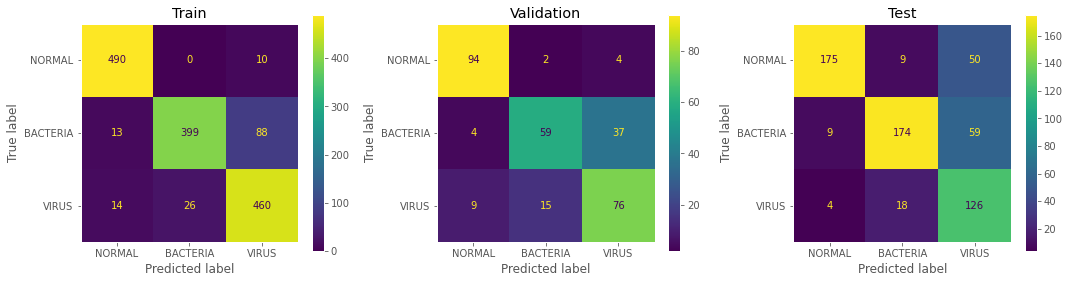

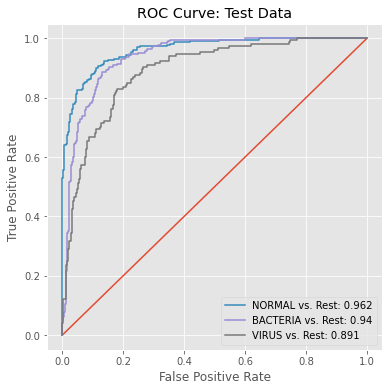

In [74]:
# Display classification reports, confusion matrices, and ROC curves.
display_metrics(model, train_data=(x_train, y_train), val_data=(x_val, y_val), test_data=(x_test, y_test))

After training this new network for 4 epochs, the metrics are not that far off what I achieved with my own neural network.

The overall test accuracy was 76.1% and the binary test accuracy was 88.5%. My neural network achieved 82.5% and and 91.8%, respectively.

### Fine-tuning

Next, I will try to improve the performance of the model by fine-tuning the parameters. I will do this by unfreezing the base model weights and training the network with a small learning rate. The goal of using a small learning rate is to mostly maintain the structure of the original model, but change it to better suit the x-ray data.